# Roach Comparison

Date: January 31st, 2025

Author: Jonah Lee

In this analysis, I compare the time-domain and frequency-domain common-mode signals across the 5 different BLAST-TNG ROACHes.

Wavelengths for each roach are given below:

- Roach 1: 500um
- Roach 2: 250um
- Roach 3: 350um
- Roach 4: 250um
- Roach 5: 250um

The observation used is BLAST-TNG's ~18-minute raster scan of RCW-92. The scan was composed of three passes in an azimuth/elevation frame. See ra_dec_slicing.ipynb for more.

## 1. Imports

In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as signal
import seaborn as sns  # used only for correlation matrices
import pandas as pd

## 2. Load and Proces Data

In [2]:
data_dir = os.path.join(os.getcwd(), 'common_modes')
roach_files = {
    2: 'roach2_it2.npy',
    4: 'roach4_it2.npy',
    5: 'roach5_it2.npy',
    # 1: 'roach1_it2.npy',
    # 3: 'roach3_it2.npy',
}

roaches = roach_files.keys()

common_modes = {}
for roach, file in roach_files.items():
    common_modes[roach] = np.load(os.path.join(data_dir, file), allow_pickle=True)
common_modes = pd.DataFrame(common_modes)

In [3]:
ctffts = {}
sampling_freq = 476.5  # Hz, average (see time_slicing.ipynb)
freq_axis = np.fft.rfftfreq(common_modes.shape[0], 1 / sampling_freq)
for roach in roaches:
    ctffts[roach] = np.fft.rfft(common_modes[roach])
ctffts = pd.DataFrame(ctffts)

In [4]:
ct_filtered = {}
for roach in roaches:
    # ct_filtered[roach] = signal.convolve(common_modes[roach], signal.windows.gaussian(5000, 200))
    ct_filtered[roach] = signal.savgol_filter(common_modes[roach], 3000, 1)
ct_filtered = pd.DataFrame(ct_filtered)

In [5]:
mean = common_modes.mean(axis=1)
mean_filtered = ct_filtered.mean(axis=1)
fft_mean = ctffts.mean(axis=1)

mean_diffs = {}
for roach in roaches:
    mean_diffs[roach] = common_modes[roach] - mean
mean_diffs = pd.DataFrame(mean_diffs)

mean_diffs_filtered = {}
for roach in roaches:
    mean_diffs_filtered[roach] = ct_filtered[roach] - mean_filtered
mean_diffs_filtered = pd.DataFrame(mean_diffs_filtered)

In [6]:
# Note: Index may be off by +- 50 as the starting index for each roach was obtained manually by trial and error.
# For exact analysis, x/y offset arrays can be exported separately for each roach

x_az = np.load(os.path.join(data_dir, 'r5_x_az.npy'), allow_pickle=True)
y_el = np.load(os.path.join(data_dir, 'r5_y_el.npy'), allow_pickle=True)
source_dist = np.sqrt(np.square(x_az) + np.square(y_el))

## 3. Plot Data

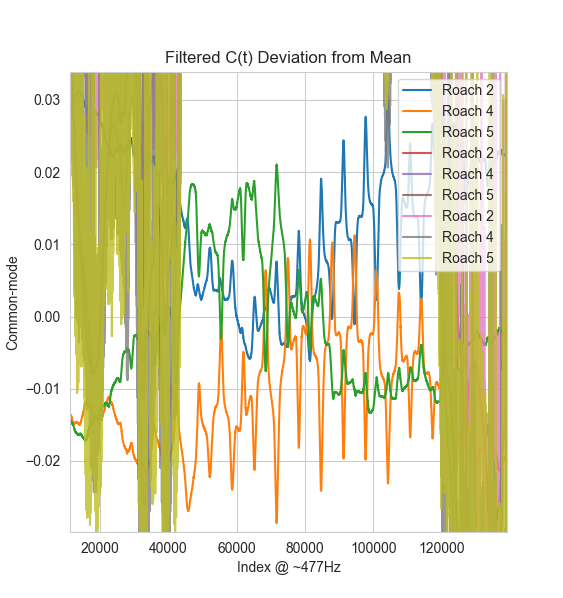

In [13]:
pass_indices = [0, 169450, 340400, 511900]

for roach in roaches:
    plt.plot(common_modes[roach], label=f'Roach {roach}', alpha=0.8)
for pass_num, i in enumerate(pass_indices):
    plt.axvline(x=i, alpha=0.5, linestyle='--')
plt.legend(loc='upper right')
plt.xlabel("Index @ ~477Hz")
plt.ylabel("Common-mode")
plt.show()

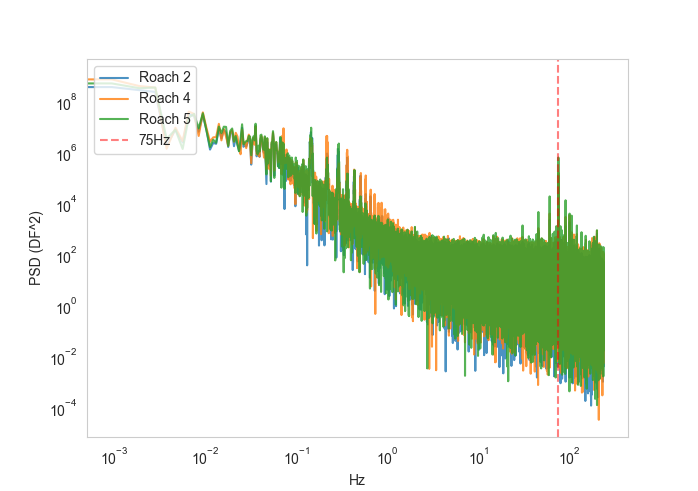

In [16]:
plt.clf()
for roach in roaches:
    plt.plot(freq_axis, np.abs(ctffts[roach]) ** 2, label=f'Roach {roach}', alpha=0.8)
# plt.axvline(x=1/7, alpha=0.5, linestyle='--', c='r', label='(7s)^-1 (horizontal scan)')
# plt.axvline(x=1/360, alpha=0.5, linestyle='--', c='r', label='(6min)^-1 (vertical pass)')
plt.axvline(x=75, alpha=0.5, linestyle='--', c='r', label='75Hz')
plt.legend(loc='upper left')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Hz")
plt.ylabel("PSD (DF^2)")
plt.grid()
plt.show()

# plt.clf()
# for roach in roaches:
#     plt.plot(freq_axis, np.abs(ctffts[roach]), label=f'Roach {roach}', alpha=0.8)
# plt.axvline(x=1/7, alpha=0.5, linestyle='--', c='r', label='(7s)^-1 (horizontal scan)')
# plt.axvline(x=1/360, alpha=0.5, linestyle='--', c='r', label='(6min)^-1 (vertical pass)')
# plt.isinteractive()
# plt.legend(loc='upper right')
# plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel("Hz")
# plt.ylabel("FFT (DF)")
# plt.grid()
# plt.show()

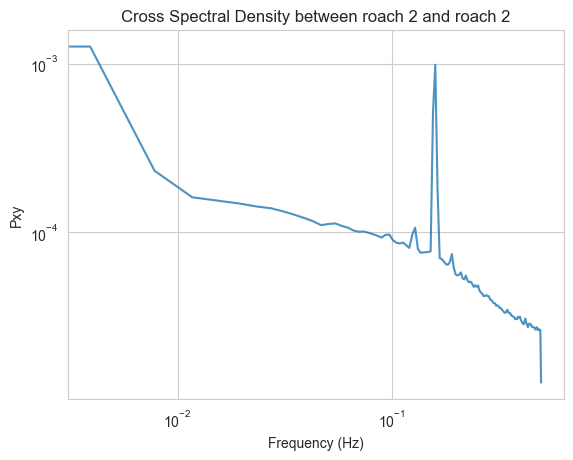

C:\Users\Jonah\PycharmProjects\spire_blasttng_diff\.venv\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Jonah\PycharmProjects\spire_blasttng_diff\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


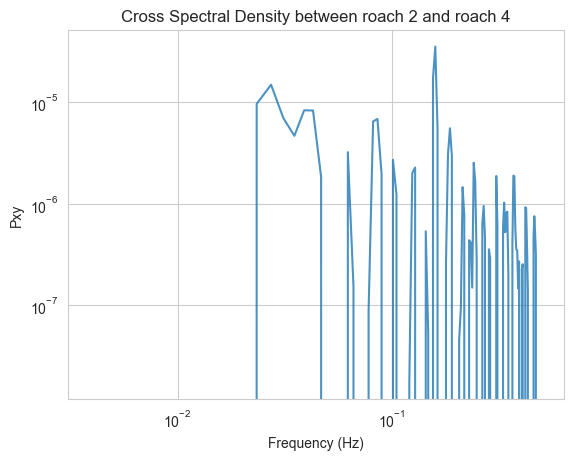

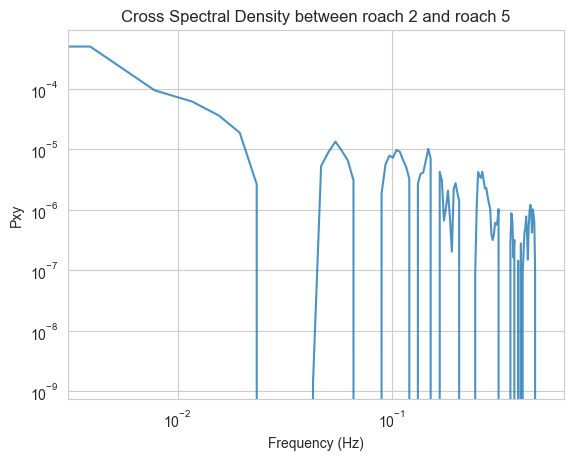

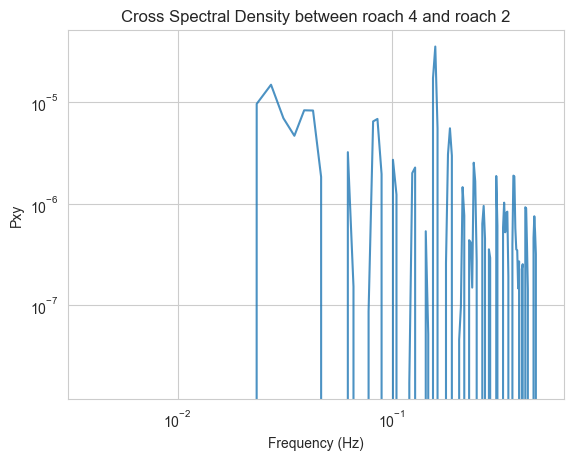

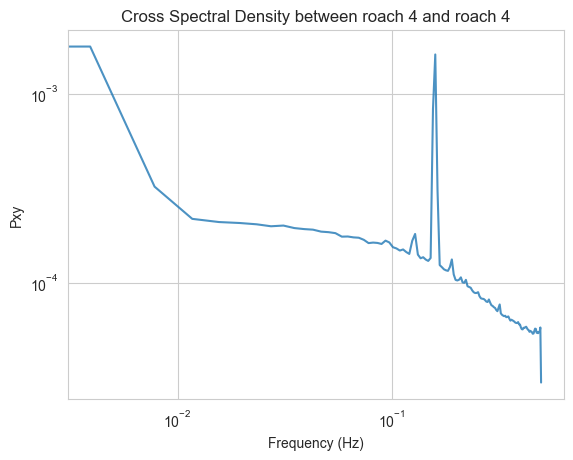

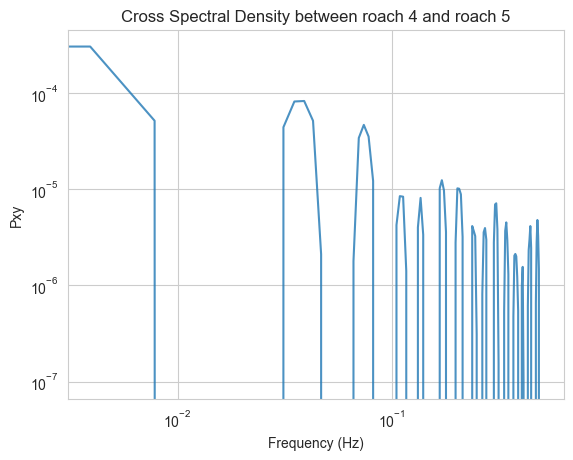

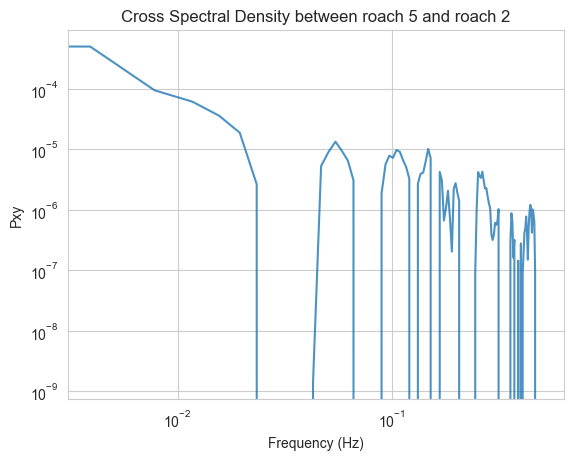

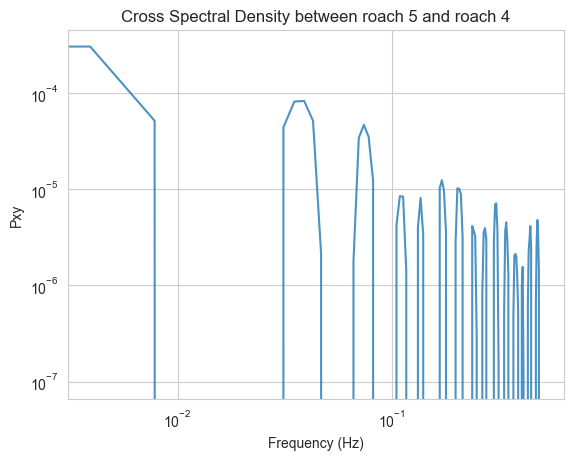

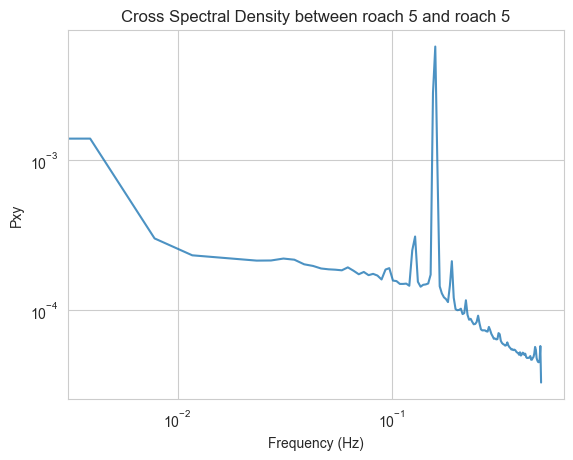

In [25]:
# cross spectral density
for ref_roach in roaches:
    for roach in roaches:
        cm1 = common_modes[ref_roach]
        cm2 = common_modes[roach]
        plt.plot(*signal.csd(cm1, cm2), alpha=0.8)
        plt.title(f'Cross Spectral Density between roach {ref_roach} and roach {roach}')
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Pxy")
        plt.xscale('log')
        plt.yscale('log')
        plt.show()

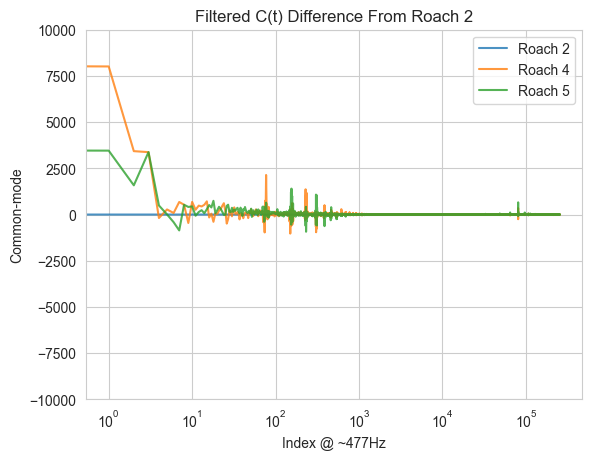

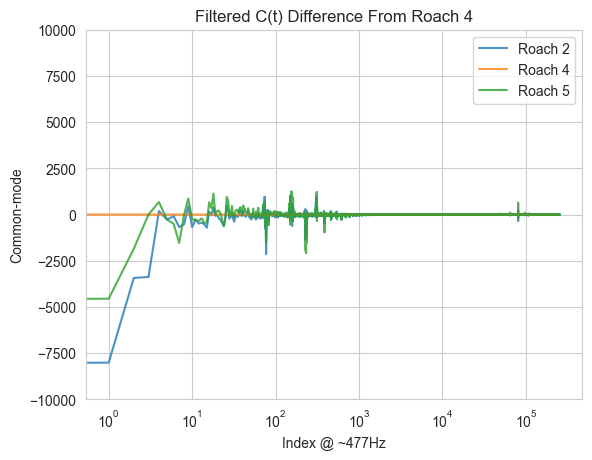

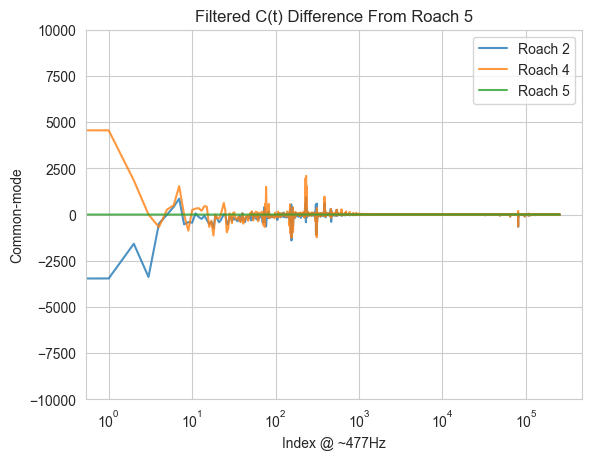

In [9]:
for ref_roach in roaches:
    for roach in roaches:
        plt.plot(np.abs(ctffts[roach]) - np.abs(ctffts[ref_roach]), label=f'Roach {roach}', alpha=0.8)
    plt.legend(loc='best')
    plt.title(f'Filtered C(t) Difference From Roach {ref_roach}')
    plt.xlabel("Index @ ~477Hz")
    plt.ylabel("Common-mode")
    plt.xscale('log')
    # plt.yscale('symlog')
    plt.ylim(-10000, 10000)
    plt.show()

for ref_roach in roaches:
    for roach in roaches:
        plt.plot(np.abs(ctffts[roach]) - np.abs(ctffts[ref_roach]), label=f'Roach {roach}', alpha=0.8)
    plt.legend(loc='best')
    plt.title(f'Filtered C(t) Difference From Roach {ref_roach}')
    plt.xlabel("Index @ ~477Hz")
    plt.ylabel("Common-mode")
    plt.xscale('log')
    # plt.yscale('symlog')
    plt.ylim(-10000, 10000)
    plt.show()

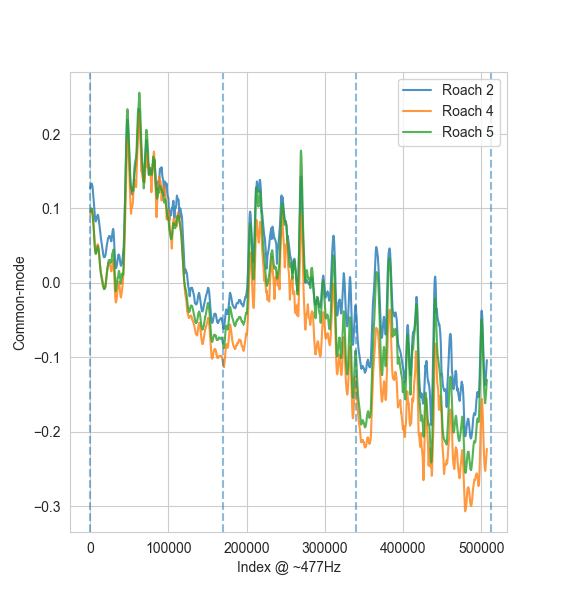

In [15]:
plt.clf()
for roach in roaches:
    plt.plot(ct_filtered[roach], label=f'Roach {roach}', alpha=0.8)
for pass_num, i in enumerate(pass_indices):
    plt.axvline(x=i, alpha=0.5, linestyle='--')
plt.legend(loc='upper right')
plt.xlabel("Index @ ~477Hz")
plt.ylabel("Common-mode")
plt.show()

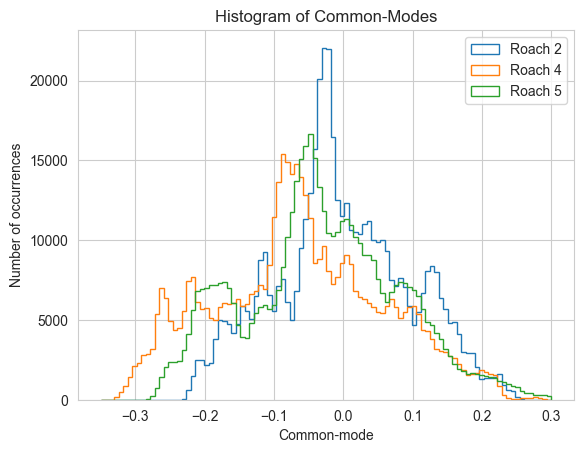

In [11]:
for roach in roaches:
    plt.hist(common_modes[roach], 100, range=(-0.35, 0.3), histtype='step', label=f'Roach {roach}')
plt.title('Histogram of Common-Modes')
plt.xlabel('Common-mode')
plt.ylabel('Number of occurrences')
plt.legend()
plt.show()

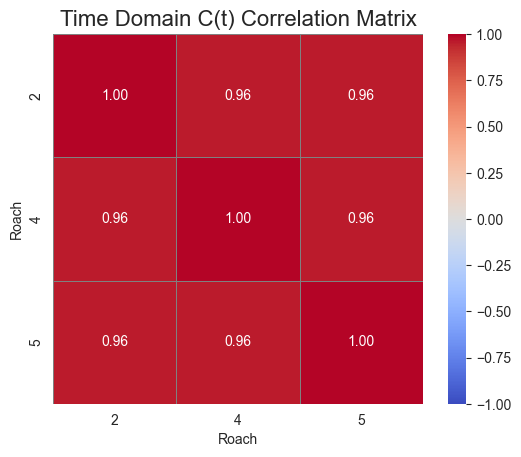

In [12]:
sns.heatmap(common_modes.corr(), annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, cbar=True, square=True,
            linewidths=0.5, linecolor='gray')
plt.title(f"Time Domain C(t) Correlation Matrix", fontsize=16)
plt.xlabel("Roach")
plt.ylabel("Roach")
plt.show()

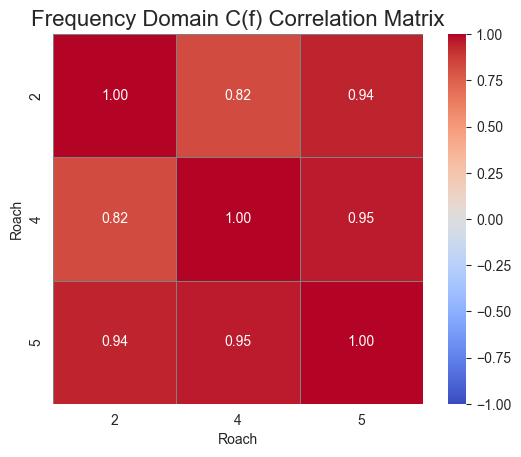

In [13]:
plt.clf()
sns.heatmap(np.abs(ctffts).corr(), annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, cbar=True, square=True,
            linewidths=0.5, linecolor='gray')
plt.title(f"Frequency Domain C(f) Correlation Matrix", fontsize=16)
plt.xlabel("Roach")
plt.ylabel("Roach")
plt.show()

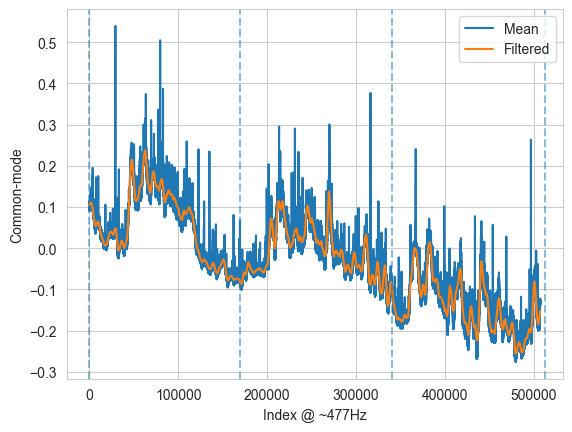

In [14]:
plt.plot(mean, label='Mean')
plt.plot(mean_filtered, label='Filtered')
for pass_num, i in enumerate(pass_indices):
    plt.axvline(x=i, alpha=0.5, linestyle='--')
plt.legend(loc='upper right')
plt.xlabel("Index @ ~477Hz")
plt.ylabel("Common-mode")
plt.show()

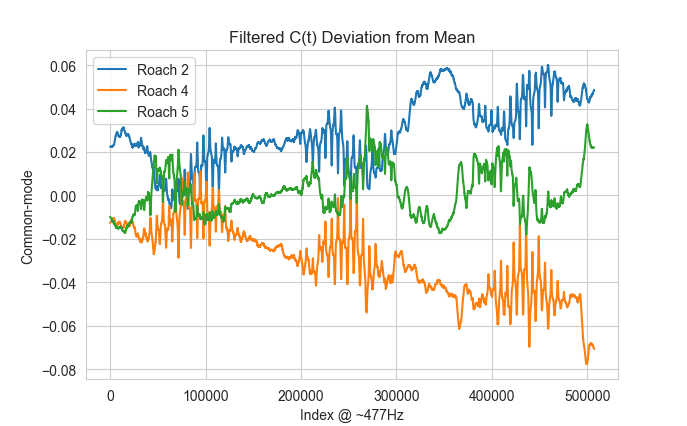

In [11]:
# for roach in roaches:
#     plt.plot(mean_diffs[roach], label=f'Roach {roach}')
# plt.legend(loc='upper right')
# plt.title('C(t) Deviation from Mean')
# plt.xlabel("Index @ ~477Hz")
# plt.ylabel("Common-mode")
# plt.show()

plt.clf()
for roach in roaches:
    plt.plot(mean_diffs_filtered[roach], label=f'Roach {roach}')
plt.legend(loc='upper left')
plt.title('Filtered C(t) Deviation from Mean')
plt.xlabel("Index @ ~477Hz")
plt.ylabel("Common-mode")
plt.show()

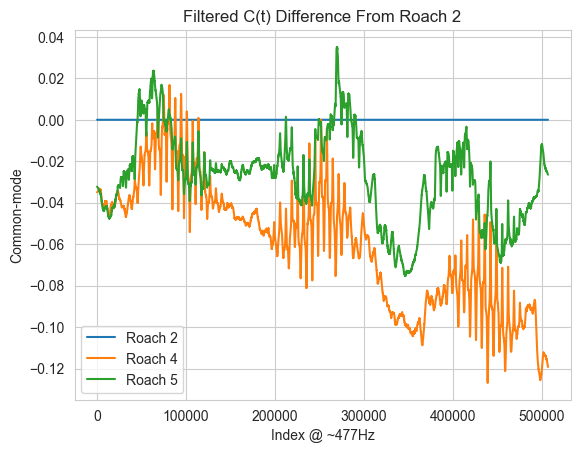

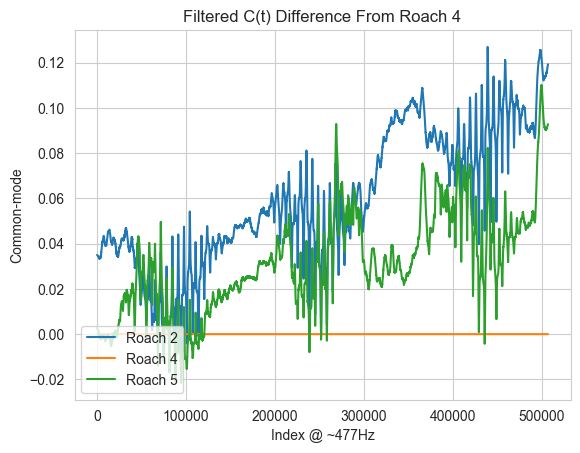

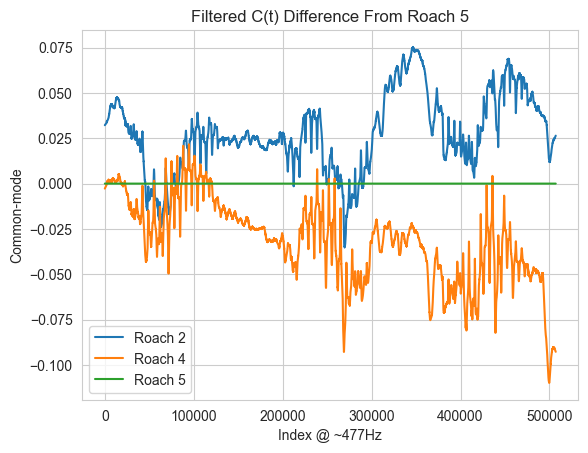

In [16]:
for ref_roach in roaches:
    for roach in roaches:
        plt.plot(ct_filtered[roach] - ct_filtered[ref_roach], label=f'Roach {roach}')
    plt.legend(loc='lower left')
    plt.title(f'Filtered C(t) Difference From Roach {ref_roach}')
    plt.xlabel("Index @ ~477Hz")
    plt.ylabel("Common-mode")
    plt.show()

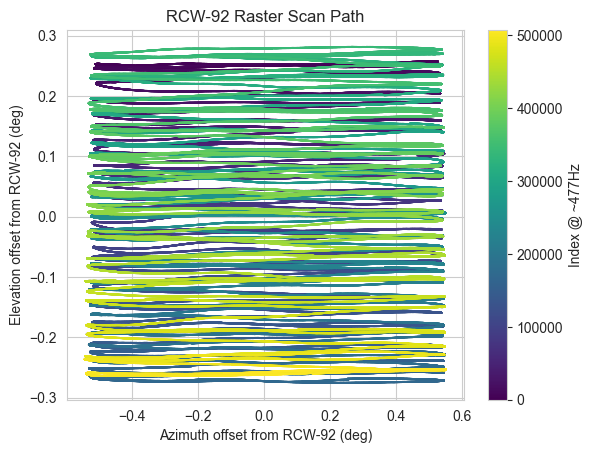

In [17]:
plt.scatter(x_az, y_el, c=range(len(x_az)), s=0.2, cmap='viridis')
plt.xlabel('Azimuth offset from RCW-92 (deg)')
plt.ylabel('Elevation offset from RCW-92 (deg)')
plt.title('RCW-92 Raster Scan Path')
plt.colorbar(label='Index @ ~477Hz')
plt.show()

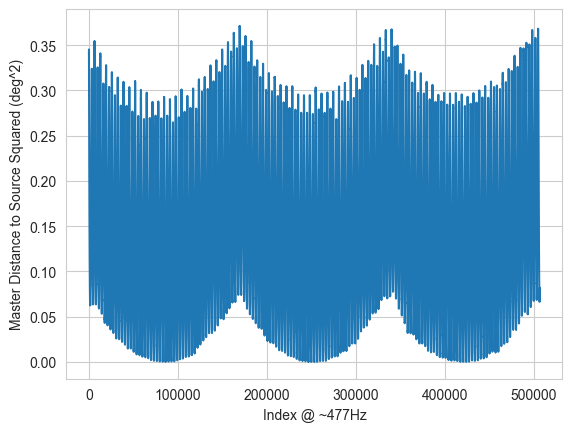

In [18]:
# plt.plot(source_dist)
# plt.xlabel('Index @ ~477Hz')
# plt.ylabel('Master Distance to Source (deg)')
# plt.show()

plt.plot(np.square(source_dist))
plt.xlabel('Index @ ~477Hz')
plt.ylabel('Master Distance to Source Squared (deg^2)')
plt.show()

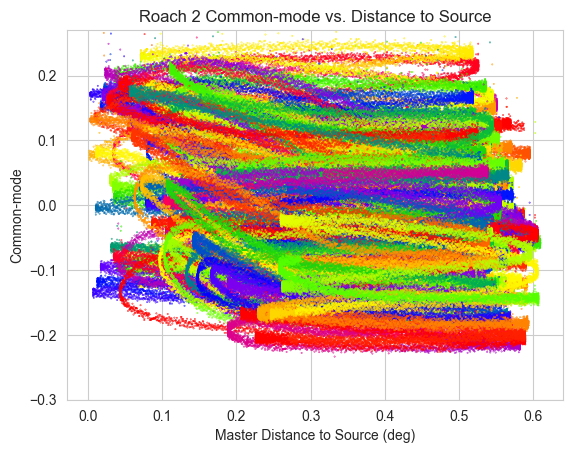

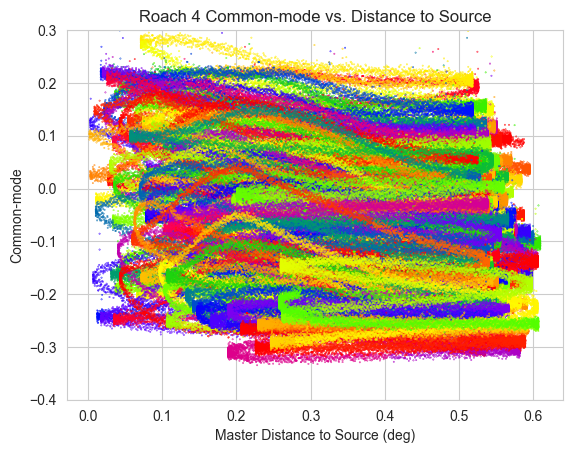

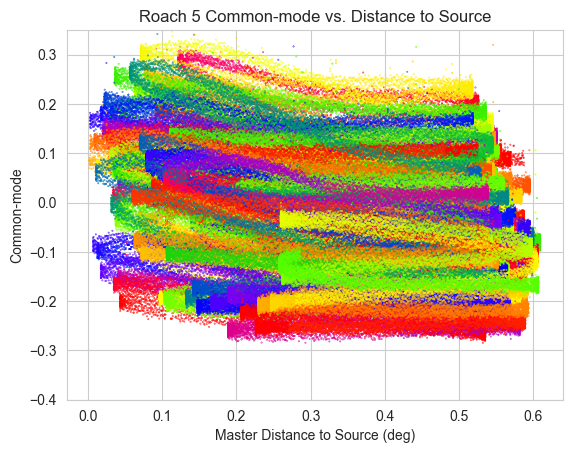

In [19]:
ylims = {
    1: (-0.1, 0.08),
    2: (-0.3, 0.27),
    3: (-0.2, 0.15),
    4: (-0.4, 0.30),
    5: (-0.4, 0.35),
}
for roach in roaches:
    plt.scatter(source_dist, common_modes[roach], s=0.1, c=range(len(source_dist)), cmap='prism')
    plt.ylim(*ylims[roach])
    plt.xlabel('Master Distance to Source (deg)')
    plt.ylabel('Common-mode')
    plt.title(f'Roach {roach} Common-mode vs. Distance to Source')
    plt.show()

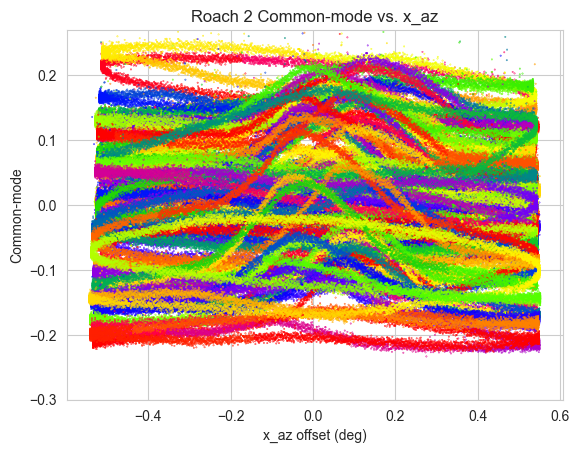

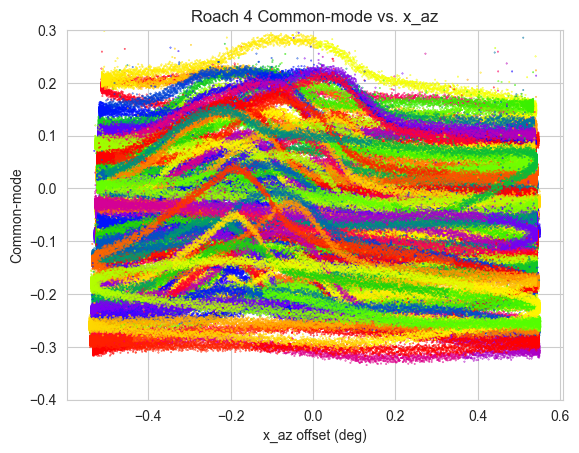

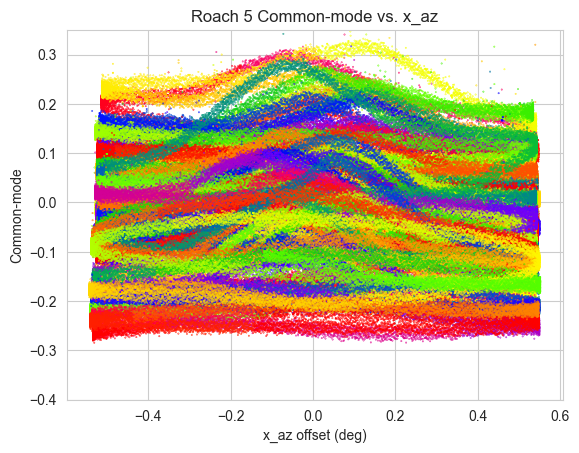

In [20]:
for roach in roaches:
    plt.scatter(x_az, common_modes[roach], s=0.1, c=range(len(source_dist)), cmap='prism')
    plt.ylim(*ylims[roach])
    plt.xlabel('x_az offset (deg)')
    plt.ylabel('Common-mode')
    plt.title(f'Roach {roach} Common-mode vs. x_az')
    plt.show()

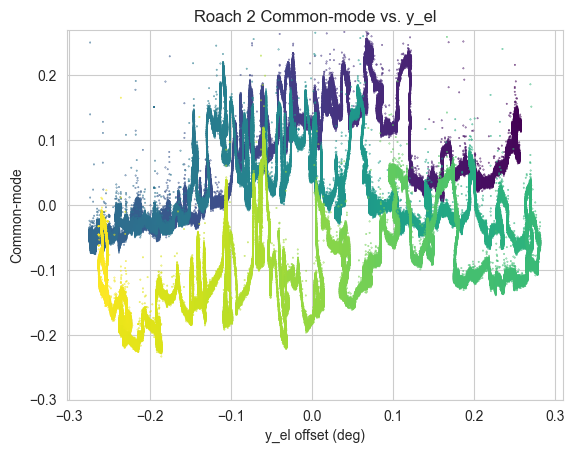

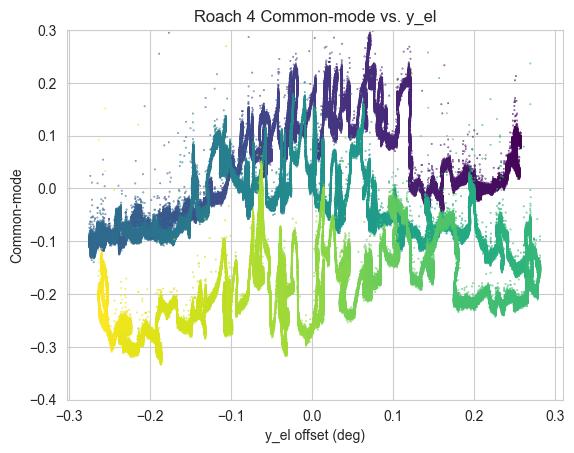

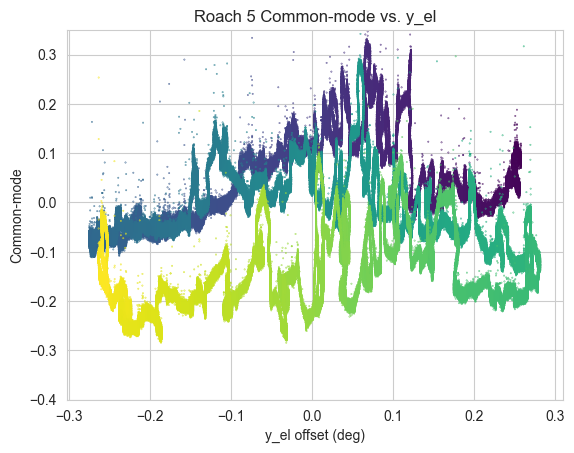

In [21]:
for roach in roaches:
    plt.scatter(y_el, common_modes[roach], s=0.1, c=range(len(source_dist)), cmap='viridis')
    plt.ylim(*ylims[roach])
    plt.xlabel('y_el offset (deg)')
    plt.ylabel('Common-mode')
    plt.title(f'Roach {roach} Common-mode vs. y_el')
    plt.show()